In [6]:
import sys
sys.path.insert(0,"../")

In [7]:
import argparse

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger, MLFlowLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os
import torch

import matplotlib.pyplot as plt

import numpy as np

import wandb
api = wandb.Api()

from causalode import models, data_utils, cv_data_utils, covid_data_utils
from azureml.core.run import Run
from causalode.utils import str2bool

import scipy

from causalode import results_processing_utils

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

def update_dict(main_dict, new_dict):
    for key in new_dict.keys():
        main_dict[key].append(new_dict[key])

# Pendulum metrics 

In [8]:
import wandb
api = wandb.Api()

sweep = api.sweep("edebrouwer/causalode/j5joxfxl") # Pendulum Neural ODE
run_names = [run.id for run in sweep.runs]

288ywy2d
Loaded model and data from ./wandb/run-20210722_122011-288ywy2d/files/causalode/288ywy2d/checkpoints/last.ckpt
lnh6zwxs
Loaded model and data from ./wandb/run-20210722_114951-lnh6zwxs/files/causalode/lnh6zwxs/checkpoints/last.ckpt
v4jizqyv
Loaded model and data from ./wandb/run-20210722_112024-v4jizqyv/files/causalode/v4jizqyv/checkpoints/last.ckpt


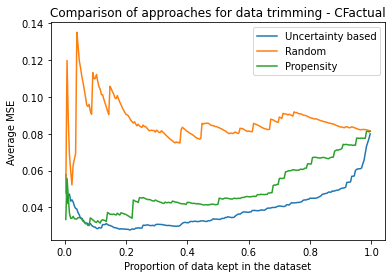

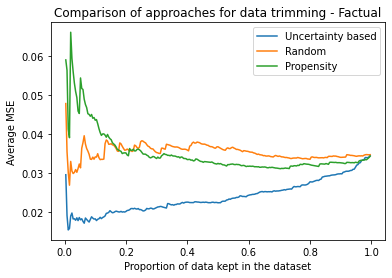

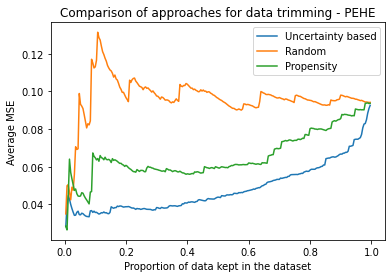

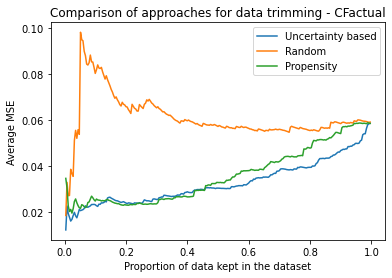

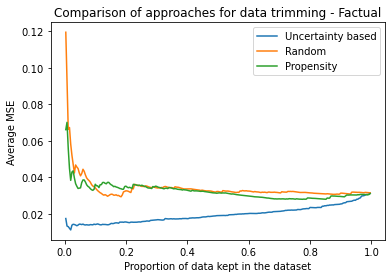

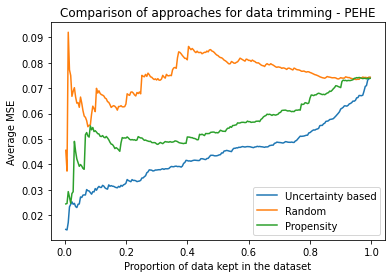

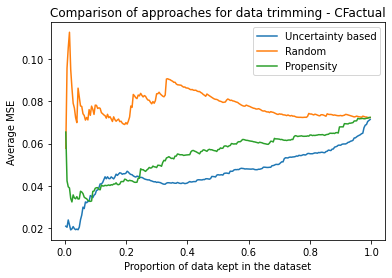

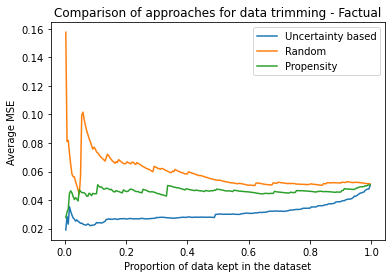

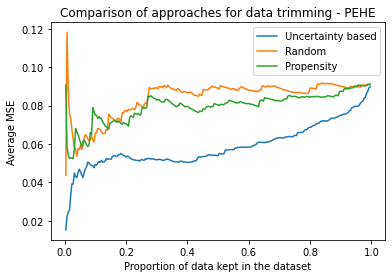

In [9]:
repeats = 10
t_lim_trimming_start = 0
t_lim_trimming_end = 5
last_model = True

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

for run_name in run_names:

    print(run_name)
    PATH = "./wandb/"
    paths = [p for p in os.listdir(PATH) if run_name in p]
    assert(len(paths)==1)
    PATH += paths[0] + "/files/causalode/"+run_name+"/checkpoints/"
    
    if last_model:
        PATH += "last.ckpt"
    else:
        PATH+= [f for f in os.listdir(PATH) if "last" not in f][0]
    model_cls = models.VariationalSDE
    model = model_cls.load_from_checkpoint(PATH)

    hparams = dict(model.hparams)

    if hparams["dataset_name"]=="cv":
        dataset_cls = cv_data_utils.CVDataModule
    elif hparams["dataset_name"]=="covid":
        dataset_cls = covid_data_utils.CovidDataModule
    else:
        dataset_cls = data_utils.PendulumDataModule
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()
    print(f"Loaded model and data from {PATH}")

    model.eval()

    Y_hat_samples_list = []
    Y_alea_std_list = []
    Y_hat_cf_samples_list = []
    Y_alea_std_cf_list = []
    Y_list = []
    Y_cf_list = []
    p_list = []
    T_list = []
    X_list = []

    with torch.no_grad():
        for i,batch in enumerate(dataset.test_dataloader()):
            X,Y, T, Y_cf, p, thetas_0 = batch
            Y_list.append(Y)
            Y_cf_list.append(Y_cf)
            p_list.append(p)
            T_list.append(T)
            X_list.append(X)
            times = torch.arange(11).float()
            #times = torch.arange(11).float()


            Y_hat_list = []
            Y_hat_cf_list = []
            Y_alea_std = []
            Y_alea_cf_std = []
            for _ in range(repeats):
                Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat, Y_std = torch.chunk(Y_hat,2,-1)
                else:
                    #Y_std = model.output_scale.repeat(Y_hat.shape)
                    Y_std = torch.zeros_like(Y_hat)

                Y_hat_list.append(Y_hat)
                Y_alea_std.append(torch.sqrt(torch.sigmoid(Y_std)))

                T_cf = (~T.bool()).float()
                Y_hat_cf, reg, logqp = model(X,T_cf,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat_cf, Y_std_cf = torch.chunk(Y_hat_cf,2,-1)
                else:
                    #Y_std_cf = model.output_scale.repeat(Y_hat_cf.shape)
                    Y_std_cf = torch.zeros_like(Y_hat_cf)
                    
                Y_hat_cf_list.append(Y_hat_cf)
                Y_alea_cf_std.append(torch.sqrt(torch.sigmoid(Y_std_cf)))

            Y_hat_samples = torch.cat(Y_hat_list,0)
            Y_alea_std = torch.cat(Y_alea_std,0)
            Y_hat_cf_samples = torch.cat(Y_hat_cf_list,0)
            Y_alea_std_cf = torch.cat(Y_alea_cf_std,0)

            Y_hat_samples_list.append(Y_hat_samples)
            Y_alea_std_list.append(Y_alea_std)
            Y_hat_cf_samples_list.append(Y_hat_cf_samples)
            Y_alea_std_cf_list.append(Y_alea_std_cf)

    Y_hat_samples = torch.cat(Y_hat_samples_list,1)
    Y_alea_std = torch.cat(Y_alea_std_list,1)
    Y_hat_cf_samples = torch.cat(Y_hat_cf_samples_list,1)
    Y_alea_std_cf = torch.cat(Y_alea_std_cf_list,1)

    Y = torch.cat(Y_list,0)
    Y_cf = torch.cat(Y_cf_list,0)
    p = torch.cat(p_list,0)
    T = torch.cat(T_list,0)
    X = torch.cat(X_list,0)

    Y_hat_mean = Y_hat_samples.mean(0)
    Y_hat_std  = Y_hat_samples.std(0)

    Y_hat_up = (Y_hat_samples+1.96*Y_alea_std).max(0)[0]
    Y_hat_down = (Y_hat_samples-1.96*Y_alea_std).min(0)[0]
    Y_hat_diff = Y_hat_up - Y_hat_down
    
    Y_hat_cf_mean = Y_hat_cf_samples.mean(0)
    Y_hat_cf_std  = Y_hat_cf_samples.std(0)

    Y_hat_cf_up = (Y_hat_cf_samples+1.96*Y_alea_std_cf).max(0)[0]
    Y_hat_cf_down = (Y_hat_cf_samples-1.96*Y_alea_std_cf).min(0)[0]
    Y_hat_cf_diff = Y_hat_cf_up - Y_hat_cf_down

    times_plot = times[1:]
    
    _, cf_dict = results_processing_utils.plot_trimming_prop(Y_cf,Y_hat_cf_mean,Y_hat_cf_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "CFactual", p = (p*T +(1-p)*(1-T)), normalize = False)

    _, f_dict = results_processing_utils.plot_trimming_prop(Y,Y_hat_mean,Y_hat_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "Factual",p = -(p*T +(1-p)*(1-T)), normalize = False)

    _, pehe_dict = results_processing_utils.plot_trimming_prop(Y-Y_cf,Y_hat_mean-Y_hat_cf_mean,Y_hat_diff+Y_hat_cf_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "PEHE", p = torch.abs(p-0.5), normalize = False)

    curve_cf_dict = results_processing_utils.update_dict(curve_cf_dict, cf_dict)
    curve_f_dict = results_processing_utils.update_dict(curve_f_dict, f_dict)
    curve_pehe_dict = results_processing_utils.update_dict(curve_pehe_dict, pehe_dict)

In [15]:
#50%
strategy_type = "uncertainty"

print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

Strategy type : propensity
Factual : 0.037126574665308+- 0.007364549674093723
CFactual : 0.043912455439567566+- 0.010068212635815144
PEHE : 0.06403981894254684+- 0.011852330528199673


In [16]:
#Full
print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

Strategy type : propensity
Factual : 0.03867090865969658+- 0.008585883304476738
CFactual : 0.07074142247438431+- 0.009317913092672825
PEHE : 0.08616345375776291+- 0.00878165103495121


# CardioVascular metrics 

In [17]:
import wandb
api = wandb.Api()

sweep = api.sweep("edebrouwer/causalode/mrgxzm14") # CV Neural ODE

run_names = [run.id for run in sweep.runs]

In [ ]:
repeats = 10
t_lim_trimming_start = 0
t_lim_trimming_end = 10
last_model = True

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

for run_name in run_names:

    print(run_name)
    PATH = "./wandb/"
    paths = [p for p in os.listdir(PATH) if run_name in p]
    assert(len(paths)==1)
    PATH += paths[0] + "/files/causalode/"+run_name+"/checkpoints/"
    
    if last_model:
        PATH += "last.ckpt"
    else:
        PATH+= [f for f in os.listdir(PATH) if "last" not in f][0]
    model_cls = models.VariationalSDE
    model = model_cls.load_from_checkpoint(PATH)

    hparams = dict(model.hparams)

    if hparams["dataset_name"]=="cv":
        dataset_cls = cv_data_utils.CVDataModule
    elif hparams["dataset_name"]=="covid":
        dataset_cls = covid_data_utils.CovidDataModule
    else:
        dataset_cls = data_utils.PendulumDataModule
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()
    print(f"Loaded model and data from {PATH}")

    model.eval()

    Y_hat_samples_list = []
    Y_alea_std_list = []
    Y_hat_cf_samples_list = []
    Y_alea_std_cf_list = []
    Y_list = []
    Y_cf_list = []
    p_list = []
    T_list = []
    X_list = []

    with torch.no_grad():
        for i,batch in enumerate(dataset.test_dataloader()):
            X,Y, T, Y_cf, p, thetas_0 = batch
            Y_list.append(Y)
            Y_cf_list.append(Y_cf)
            p_list.append(p)
            T_list.append(T)
            X_list.append(X)
            times = torch.arange(11).float()
            #times = torch.arange(11).float()


            Y_hat_list = []
            Y_hat_cf_list = []
            Y_alea_std = []
            Y_alea_cf_std = []
            for _ in range(repeats):
                Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat, Y_std = torch.chunk(Y_hat,2,-1)
                else:
                    #Y_std = model.output_scale.repeat(Y_hat.shape)
                    Y_std = torch.zeros_like(Y_hat)

                Y_hat_list.append(Y_hat)
                Y_alea_std.append(torch.sqrt(torch.sigmoid(Y_std)))

                T_cf = (~T.bool()).float()
                Y_hat_cf, reg, logqp = model(X,T_cf,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat_cf, Y_std_cf = torch.chunk(Y_hat_cf,2,-1)
                else:
                    #Y_std_cf = model.output_scale.repeat(Y_hat_cf.shape)
                    Y_std_cf = torch.zeros_like(Y_hat_cf)
                    
                Y_hat_cf_list.append(Y_hat_cf)
                Y_alea_cf_std.append(torch.sqrt(torch.sigmoid(Y_std_cf)))

            Y_hat_samples = torch.cat(Y_hat_list,0)
            Y_alea_std = torch.cat(Y_alea_std,0)
            Y_hat_cf_samples = torch.cat(Y_hat_cf_list,0)
            Y_alea_std_cf = torch.cat(Y_alea_cf_std,0)

            Y_hat_samples_list.append(Y_hat_samples)
            Y_alea_std_list.append(Y_alea_std)
            Y_hat_cf_samples_list.append(Y_hat_cf_samples)
            Y_alea_std_cf_list.append(Y_alea_std_cf)

    Y_hat_samples = torch.cat(Y_hat_samples_list,1)
    Y_alea_std = torch.cat(Y_alea_std_list,1)
    Y_hat_cf_samples = torch.cat(Y_hat_cf_samples_list,1)
    Y_alea_std_cf = torch.cat(Y_alea_std_cf_list,1)

    Y = torch.cat(Y_list,0)
    Y_cf = torch.cat(Y_cf_list,0)
    p = torch.cat(p_list,0)
    T = torch.cat(T_list,0)
    X = torch.cat(X_list,0)

    Y_hat_mean = Y_hat_samples.mean(0)
    Y_hat_std  = Y_hat_samples.std(0)

    Y_hat_up = (Y_hat_samples+1.96*Y_alea_std).max(0)[0]
    Y_hat_down = (Y_hat_samples-1.96*Y_alea_std).min(0)[0]
    Y_hat_diff = Y_hat_up - Y_hat_down
    
    Y_hat_cf_mean = Y_hat_cf_samples.mean(0)
    Y_hat_cf_std  = Y_hat_cf_samples.std(0)

    Y_hat_cf_up = (Y_hat_cf_samples+1.96*Y_alea_std_cf).max(0)[0]
    Y_hat_cf_down = (Y_hat_cf_samples-1.96*Y_alea_std_cf).min(0)[0]
    Y_hat_cf_diff = Y_hat_cf_up - Y_hat_cf_down

    times_plot = times[1:]
    
    _, cf_dict = results_processing_utils.plot_trimming_prop(Y_cf,Y_hat_cf_mean,Y_hat_cf_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "CFactual", p = (p*T +(1-p)*(1-T)), normalize = False)

    _, f_dict = results_processing_utils.plot_trimming_prop(Y,Y_hat_mean,Y_hat_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "Factual",p = -(p*T +(1-p)*(1-T)), normalize = False)

    _, pehe_dict = results_processing_utils.plot_trimming_prop(Y-Y_cf,Y_hat_mean-Y_hat_cf_mean,Y_hat_diff+Y_hat_cf_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "PEHE", p = torch.abs(p-0.5), normalize = False)

    curve_cf_dict = results_processing_utils.update_dict(curve_cf_dict, cf_dict)
    curve_f_dict = results_processing_utils.update_dict(curve_f_dict, f_dict)
    curve_pehe_dict = results_processing_utils.update_dict(curve_pehe_dict, pehe_dict)

6x55u2vb
Loaded model and data from ./wandb/run-20210824_125705-6x55u2vb/files/causalode/6x55u2vb/checkpoints/last.ckpt


In [ ]:
#50%
strategy_type = "propensity"

print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

In [ ]:
#Full
print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

# Covid metrics 

In [ ]:
import wandb
api = wandb.Api()

sweep = api.sweep("edebrouwer/causalode/mqap3r2x") # Covid Neural ODE

run_names = [run.id for run in sweep.runs]

In [ ]:
repeats = 10
t_lim_trimming_start = 0
t_lim_trimming_end = 10
last_model = True

curve_cf_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_f_dict = {"random" : [], "propensity": [], "uncertainty": []}
curve_pehe_dict = {"random" : [], "propensity": [], "uncertainty": []}

for run_name in run_names:

    print(run_name)
    PATH = "./wandb/"
    paths = [p for p in os.listdir(PATH) if run_name in p]
    assert(len(paths)==1)
    PATH += paths[0] + "/files/causalode/"+run_name+"/checkpoints/"
    
    if last_model:
        PATH += "last.ckpt"
    else:
        PATH+= [f for f in os.listdir(PATH) if "last" not in f][0]
    model_cls = models.VariationalSDE
    model = model_cls.load_from_checkpoint(PATH)

    hparams = dict(model.hparams)

    if hparams["dataset_name"]=="cv":
        dataset_cls = cv_data_utils.CVDataModule
    elif hparams["dataset_name"]=="covid":
        dataset_cls = covid_data_utils.CovidDataModule
    else:
        dataset_cls = data_utils.PendulumDataModule
    dataset = dataset_cls(**hparams)
    dataset.prepare_data()
    print(f"Loaded model and data from {PATH}")

    model.eval()

    Y_hat_samples_list = []
    Y_alea_std_list = []
    Y_hat_cf_samples_list = []
    Y_alea_std_cf_list = []
    Y_list = []
    Y_cf_list = []
    p_list = []
    T_list = []
    X_list = []

    with torch.no_grad():
        for i,batch in enumerate(dataset.test_dataloader()):
            X,Y, T, Y_cf, p, thetas_0 = batch
            Y_list.append(Y)
            Y_cf_list.append(Y_cf)
            p_list.append(p)
            T_list.append(T)
            X_list.append(X)
            times = torch.arange(11).float()
            #times = torch.arange(11).float()


            Y_hat_list = []
            Y_hat_cf_list = []
            Y_alea_std = []
            Y_alea_cf_std = []
            for _ in range(repeats):
                Y_hat, reg, logqp = model(X,T,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat, Y_std = torch.chunk(Y_hat,2,-1)
                else:
                    #Y_std = model.output_scale.repeat(Y_hat.shape)
                    Y_std = torch.zeros_like(Y_hat)

                Y_hat_list.append(Y_hat)
                Y_alea_std.append(torch.sqrt(torch.sigmoid(Y_std)))

                T_cf = (~T.bool()).float()
                Y_hat_cf, reg, logqp = model(X,T_cf,return_decoded_u=True, times=times)
                if model.std_dev:
                    Y_hat_cf, Y_std_cf = torch.chunk(Y_hat_cf,2,-1)
                else:
                    #Y_std_cf = model.output_scale.repeat(Y_hat_cf.shape)
                    Y_std_cf = torch.zeros_like(Y_hat_cf)
                    
                Y_hat_cf_list.append(Y_hat_cf)
                Y_alea_cf_std.append(torch.sqrt(torch.sigmoid(Y_std_cf)))

            Y_hat_samples = torch.cat(Y_hat_list,0)
            Y_alea_std = torch.cat(Y_alea_std,0)
            Y_hat_cf_samples = torch.cat(Y_hat_cf_list,0)
            Y_alea_std_cf = torch.cat(Y_alea_cf_std,0)

            Y_hat_samples_list.append(Y_hat_samples)
            Y_alea_std_list.append(Y_alea_std)
            Y_hat_cf_samples_list.append(Y_hat_cf_samples)
            Y_alea_std_cf_list.append(Y_alea_std_cf)

    Y_hat_samples = torch.cat(Y_hat_samples_list,1)
    Y_alea_std = torch.cat(Y_alea_std_list,1)
    Y_hat_cf_samples = torch.cat(Y_hat_cf_samples_list,1)
    Y_alea_std_cf = torch.cat(Y_alea_std_cf_list,1)

    Y = torch.cat(Y_list,0)
    Y_cf = torch.cat(Y_cf_list,0)
    p = torch.cat(p_list,0)
    T = torch.cat(T_list,0)
    X = torch.cat(X_list,0)

    Y_hat_mean = Y_hat_samples.mean(0)
    Y_hat_std  = Y_hat_samples.std(0)

    Y_hat_up = (Y_hat_samples+1.96*Y_alea_std).max(0)[0]
    Y_hat_down = (Y_hat_samples-1.96*Y_alea_std).min(0)[0]
    Y_hat_diff = Y_hat_up - Y_hat_down
    
    Y_hat_cf_mean = Y_hat_cf_samples.mean(0)
    Y_hat_cf_std  = Y_hat_cf_samples.std(0)

    Y_hat_cf_up = (Y_hat_cf_samples+1.96*Y_alea_std_cf).max(0)[0]
    Y_hat_cf_down = (Y_hat_cf_samples-1.96*Y_alea_std_cf).min(0)[0]
    Y_hat_cf_diff = Y_hat_cf_up - Y_hat_cf_down

    times_plot = times[1:]
    
    _, cf_dict = results_processing_utils.plot_trimming_prop(Y_cf,Y_hat_cf_mean,Y_hat_cf_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "CFactual", p = (p*T +(1-p)*(1-T)), normalize = False)

    _, f_dict = results_processing_utils.plot_trimming_prop(Y,Y_hat_mean,Y_hat_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "Factual",p = -(p*T +(1-p)*(1-T)), normalize = False)

    _, pehe_dict = results_processing_utils.plot_trimming_prop(Y-Y_cf,Y_hat_mean-Y_hat_cf_mean,Y_hat_diff+Y_hat_cf_diff,t_lim_trimming_start,t_lim_trimming_end,times_plot, data_type = "PEHE", p = torch.abs(p-0.5), normalize = False)

    curve_cf_dict = results_processing_utils.update_dict(curve_cf_dict, cf_dict)
    curve_f_dict = results_processing_utils.update_dict(curve_f_dict, f_dict)
    curve_pehe_dict = results_processing_utils.update_dict(curve_pehe_dict, pehe_dict)

In [ ]:
#50%
strategy_type = "uncertainty"

print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][int(num_evals/2)] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")

In [ ]:
#Full
print(f"Strategy type : {strategy_type}")

num_evals = len(curve_cf_dict[strategy_type][0])
num_sims =  len(curve_cf_dict[strategy_type])

rmse_50 = np.array([curve_f_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_50_mean = rmse_50.mean()
rmse_50_std = rmse_50.std()
print(f"Factual : {rmse_50_mean}+- {rmse_50_std}")

rmse_cf_50 = np.array([curve_cf_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_cf_50_mean = rmse_cf_50.mean()
rmse_cf_50_std = rmse_cf_50.std()
print(f"CFactual : {rmse_cf_50_mean}+- {rmse_cf_50_std}")

rmse_pehe_50 = np.array([curve_pehe_dict[strategy_type][i][-1] for i in range(num_sims)])
rmse_pehe_50_mean = rmse_pehe_50.mean()
rmse_pehe_50_std = rmse_pehe_50.std()
print(f"PEHE : {rmse_pehe_50_mean}+- {rmse_pehe_50_std}")